## DATA PROCESSING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc 
import time

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

%matplotlib inline

In [2]:
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [3]:
(market_train_df, news_train_df) = env.get_training_data()

In [4]:
news_train_df.columns

Index(['time', 'sourceTimestamp', 'firstCreated', 'sourceId', 'headline',
       'urgency', 'takeSequence', 'provider', 'subjects', 'audiences',
       'bodySize', 'companyCount', 'headlineTag', 'marketCommentary',
       'sentenceCount', 'wordCount', 'assetCodes', 'assetName',
       'firstMentionSentence', 'relevance', 'sentimentClass',
       'sentimentNegative', 'sentimentNeutral', 'sentimentPositive',
       'sentimentWordCount', 'noveltyCount12H', 'noveltyCount24H',
       'noveltyCount3D', 'noveltyCount5D', 'noveltyCount7D', 'volumeCounts12H',
       'volumeCounts24H', 'volumeCounts3D', 'volumeCounts5D',
       'volumeCounts7D'],
      dtype='object')

In [5]:
#dropping unnessary columns from the news dataset
drop_list = ['sourceTimestamp', 'firstCreated', 'sourceId', 'headline','takeSequence', 'subjects', 'audiences',
             'bodySize', 'marketCommentary']
news_train_df.drop(drop_list, axis=1, inplace=True)

In [6]:
#remove {} and '' from the assetCodes column of the news_train_df
news_train_df['assetCodes'] = news_train_df['assetCodes'].apply(lambda x:x[1:-1].replace("'", ""))

In [7]:
#Unstack news dataset using the assetCodes column
assetCodes = []
indices = []

for i, val in news_train_df['assetCodes'].iteritems():
    codes = val.split(",")
    assetCodes.extend(codes)
    list_index = [int(i)]*len(codes)
    indices.extend(list_index)

index_df = pd.DataFrame({'new_index': indices, 'assetCode': assetCodes})
del assetCodes, indices
gc.collect()

22

In [8]:
#Take a look at the new index_df dataframe
index_df.head()

,new_index,assetCode
0,0,0857.HK
1,0,PTR.N
2,0,0857.DE
3,0,0857.F
4,1,STA.N


In [9]:
#Dropping the assetCodes column before unstacking the news dataset
news_train_df.drop(['assetCodes'], axis=1, inplace=True)

In [10]:
#Merging the news_train_df and the index_df to unstack the news dataframe
news_train_df['new_index'] = news_train_df.index.copy()
news_unstack = index_df.merge(news_train_df, how='left', on='new_index')
news_unstack.drop(['new_index'], axis=1, inplace=True)
del index_df, news_train_df
gc.collect()
news_unstack.head()

,assetCode,time,urgency,provider,companyCount,headlineTag,sentenceCount,wordCount,assetName,firstMentionSentence,relevance,sentimentClass,sentimentNegative,sentimentNeutral,sentimentPositive,sentimentWordCount,noveltyCount12H,noveltyCount24H,noveltyCount3D,noveltyCount5D,noveltyCount7D,volumeCounts12H,volumeCounts24H,volumeCounts3D,volumeCounts5D,volumeCounts7D
0,0857.HK,2007-01-01 04:29:32+00:00,3,RTRS,1,,11,275,PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
1,PTR.N,2007-01-01 04:29:32+00:00,3,RTRS,1,,11,275,PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
2,0857.DE,2007-01-01 04:29:32+00:00,3,RTRS,1,,11,275,PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
3,0857.F,2007-01-01 04:29:32+00:00,3,RTRS,1,,11,275,PetroChina Co Ltd,6,0.235702,-1,0.500739,0.419327,0.079934,73,0,0,0,0,0,0,0,3,6,7
4,STA.N,2007-01-01 07:03:35+00:00,3,RTRS,1,FEATURE,55,907,Travelers Companies Inc,8,0.447214,-1,0.600082,0.345853,0.054064,62,1,1,1,1,1,1,1,3,3,3


In [11]:
#Look at how many data rows there are in the unstacked news dataset and the market dataset and determine if there would be
#memory issues
news_unstack.shape

(18821962, 26)

In [12]:
market_train_df.shape

(4072956, 16)

By checking the number of rows that the unstacked news dataset has versus the market dataset, I decided that it would be best to group the unstacked news dataset by date and assetCode to reduce the number of datapoints, thus helping us in term of running into memory issues. 

In [13]:
#Group the news dataset by date and assetCode columns
news_unstack['date'] = news_unstack.time.dt.date
group_news = news_unstack.groupby(['assetCode', 'date']).agg(['mean'])
group_news.columns = pd.Index(["{}_{}".format(i[0], i[1]) for i in group_news.columns.tolist()])
group_news.reset_index(inplace=True)
del news_unstack
gc.collect()

119

In [14]:
group_news.head()

,assetCode,date,urgency_mean,companyCount_mean,sentenceCount_mean,wordCount_mean,firstMentionSentence_mean,relevance_mean,sentimentClass_mean,sentimentNegative_mean,sentimentNeutral_mean,sentimentPositive_mean,sentimentWordCount_mean,noveltyCount12H_mean,noveltyCount24H_mean,noveltyCount3D_mean,noveltyCount5D_mean,noveltyCount7D_mean,volumeCounts12H_mean,volumeCounts24H_mean,volumeCounts3D_mean,volumeCounts5D_mean,volumeCounts7D_mean
0,0005.HK,2007-01-02,3.000000,3.200000,10.600000,272.8,2.800000,0.644895,0.20,0.055284,0.642587,0.302128,122.80,0.600000,0.600000,0.600000,1.600000,1.800000,2.200000,2.200000,2.200000,5.600000,9.800000
1,0005.HK,2007-01-03,3.000000,3.300000,59.500000,736.3,3.500000,0.319020,0.60,0.178223,0.291784,0.529992,269.00,0.400000,0.400000,0.400000,0.400000,0.600000,5.300000,9.200000,10.900000,13.300000,16.400000
2,0005.HK,2007-01-04,3.000000,1.666667,36.666667,482.0,3.000000,0.512449,1.00,0.161406,0.351436,0.487159,216.00,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,8.666667,19.666667,19.666667,23.333333
3,0005.HK,2007-01-05,3.000000,2.750000,10.500000,256.5,5.500000,0.349146,0.75,0.032474,0.388068,0.579458,78.25,0.250000,0.250000,0.750000,1.250000,1.500000,1.500000,3.250000,21.000000,23.500000,26.250000
4,0005.HK,2007-01-07,2.333333,1.000000,4.333333,135.0,0.666667,1.000000,1.00,0.077000,0.337398,0.585602,135.00,0.666667,0.666667,0.666667,0.666667,0.666667,2.333333,2.333333,6.333333,22.333333,28.333333


In [15]:
group_news.shape

(3839401, 23)

In [16]:
#Merging the grouped news dataset and the market dataset using data and assetCode
market_train_df['date'] = market_train_df.time.dt.date
market_news_df = market_train_df.merge(group_news, how='left', on=['assetCode', 'date'])
del market_train_df, group_news
gc.collect()
market_news_df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,date,urgency_mean,companyCount_mean,sentenceCount_mean,wordCount_mean,firstMentionSentence_mean,relevance_mean,sentimentClass_mean,sentimentNegative_mean,sentimentNeutral_mean,sentimentPositive_mean,sentimentWordCount_mean,noveltyCount12H_mean,noveltyCount24H_mean,noveltyCount3D_mean,noveltyCount5D_mean,noveltyCount7D_mean,volumeCounts12H_mean,volumeCounts24H_mean,volumeCounts3D_mean,volumeCounts5D_mean,volumeCounts7D_mean
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0,2007-02-01,3.0,6.500000,33.000000,893.000000,9.000000,0.533333,0.50,0.080418,0.568264,0.351318,418.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.500000,4.50,6.000000,7.000000
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0,2007-02-01,2.0,2.166667,12.166667,348.416667,0.916667,0.958333,0.25,0.138128,0.412758,0.449114,284.333333,1.833333,1.833333,1.833333,1.833333,3.916667,6.666667,6.666667,10.25,10.666667,34.333333
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0,2007-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0,2007-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0,2007-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## MODEL SELECTION

In [17]:
#Save necessary variables for reporting and predicting later
#Convert the target variable returnsOpenNextMktres10 into 0 or 1. The value would be 1 if the returns is greater than 0. 
target= (market_news_df.returnsOpenNextMktres10 >= 0).astype('int8') 
universe = market_news_df.universe.astype('int8')
date = market_news_df.date

In [18]:
#Drop the target variable, universe, time, assetCode, and assetName and keep all features
features = market_news_df.drop(['returnsOpenNextMktres10', 'time', 'date', 'assetCode', 'assetName'], axis=1)
features = features.astype('float32')
features = features.fillna(features.mean())

Since the problem is to predict whether the returnsOpenNextMktres10 would go up or down, we can use a binary classifier such as Logistic Regression to accomplish the task. We can start solving the problem by using a simple Logistic Regression classifier and then explore how to tune its parameters to get a better model. In addition, we can also conduct the same process using different classifiers/nodels and compare their performance. 

In [19]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

clf = LogisticRegression()

start_time = time.time()
clf.fit(X_train, y_train)
print ('The training time using Logistic Regression is: {}'.format(time.time()-start_time))
       
print ('The accuracy score is', accuracy_score(clf.predict(X_test), y_test))
print ('The cross-entropy loss for the Logistic Regression model is', log_loss(clf.predict(X_test), y_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



The training time using Logistic Regression is: 57.66270875930786
The accuracy score is 0.5111945612036455
The cross-entropy loss for the Logistic Regression model is 16.88275081326582


In [20]:
from sklearn.metrics import roc_auc_score

clf_auc = roc_auc_score(clf.predict(X_test), y_test)
print ('The auc score of the first logistic regression model is ', clf_auc)

The auc score of the first logistic regression model is  0.5141646363839826


In [21]:
lr_feature_importance = pd.DataFrame({'variables': X_train.columns.tolist(),
                                     'feature_importance': clf.coef_.tolist()[0]})
lr_feature_importance = lr_feature_importance.sort_values('feature_importance', ascending=False)

Text(0.5,1,'Feature Importance of the Logistic Regression')

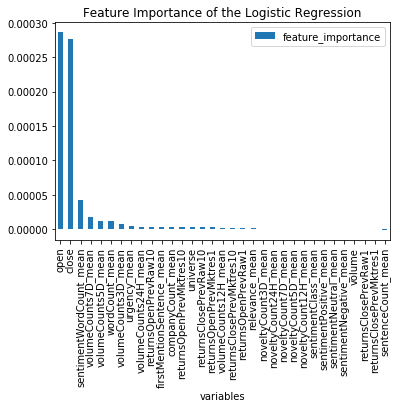

In [22]:
lr_feature_importance.plot.bar(x='variables')
plt.title("Feature Importance of the Logistic Regression")

In [23]:
print ('The best three features of logistic regression are: {}'.format(lr_feature_importance.variables.values[:3]))

The best three features of logistic regression are: ['open' 'close' 'sentimentWordCount_mean']


In [24]:
lr_feature_importance

,variables,feature_importance
2,open,2.863599e-04
1,close,2.766919e-04
22,sentimentWordCount_mean,4.287779e-05
32,volumeCounts7D_mean,1.754456e-05
31,volumeCounts5D_mean,1.195700e-05
15,wordCount_mean,1.129011e-05
30,volumeCounts3D_mean,8.156623e-06
12,urgency_mean,4.548383e-06
29,volumeCounts24H_mean,3.643019e-06
8,returnsOpenPrevRaw10,3.533752e-06


Let's try using a different model to see if we could get any thing better. In thid case, I chose to use LightGMB model due to its ability to handle large size dataset and how fast it runs. Light GBM is a gradient boosting framework which uses tree-based learning algorithm. One special thing about this model is its speed in running with large dataset, which makes it a perfect choice for this case, 

In [25]:
#try out lgb
import lightgbm as lgb

params = {'learning_rate': 0.1, 
         'max_depth': 10, 
         'objective': 'binary', 
         'metric': ['accuracy', 'auc', 'log_loss'], 
         'seed': 123}

start_time = time.time()
lgb_model = lgb.train(params, train_set=lgb.Dataset(X_train, label=y_train), 
                      num_boost_round=1000, valid_sets=[lgb.Dataset(X_train, label=y_train), 
                                                      lgb.Dataset(X_test, label=y_test)], 
                     early_stopping_rounds=100)
print ('The training time using LightGBM is: {}'.format(time.time()-start_time))

[1]	valid_0's auc: 0.555536	valid_1's auc: 0.554539
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.556702	valid_1's auc: 0.55589
[3]	valid_0's auc: 0.55784	valid_1's auc: 0.557126
[4]	valid_0's auc: 0.558378	valid_1's auc: 0.557678
[5]	valid_0's auc: 0.558798	valid_1's auc: 0.558115
[6]	valid_0's auc: 0.55909	valid_1's auc: 0.558415
[7]	valid_0's auc: 0.559252	valid_1's auc: 0.558565
[8]	valid_0's auc: 0.559513	valid_1's auc: 0.558831
[9]	valid_0's auc: 0.559726	valid_1's auc: 0.559056
[10]	valid_0's auc: 0.559863	valid_1's auc: 0.559191
[11]	valid_0's auc: 0.560179	valid_1's auc: 0.559465
[12]	valid_0's auc: 0.560299	valid_1's auc: 0.559562
[13]	valid_0's auc: 0.560468	valid_1's auc: 0.559665
[14]	valid_0's auc: 0.560594	valid_1's auc: 0.559782
[15]	valid_0's auc: 0.560737	valid_1's auc: 0.559914
[16]	valid_0's auc: 0.560828	valid_1's auc: 0.559971
[17]	valid_0's auc: 0.56097	valid_1's auc: 0.560125
[18]	valid_0's auc: 0.561159	valid_1's auc: 0.560

[155]	valid_0's auc: 0.569806	valid_1's auc: 0.564516
[156]	valid_0's auc: 0.569829	valid_1's auc: 0.564509
[157]	valid_0's auc: 0.569867	valid_1's auc: 0.564512
[158]	valid_0's auc: 0.569897	valid_1's auc: 0.564511
[159]	valid_0's auc: 0.569922	valid_1's auc: 0.564508
[160]	valid_0's auc: 0.569968	valid_1's auc: 0.564543
[161]	valid_0's auc: 0.570023	valid_1's auc: 0.564559
[162]	valid_0's auc: 0.570071	valid_1's auc: 0.564574
[163]	valid_0's auc: 0.57011	valid_1's auc: 0.564579
[164]	valid_0's auc: 0.57013	valid_1's auc: 0.564578
[165]	valid_0's auc: 0.570168	valid_1's auc: 0.564595
[166]	valid_0's auc: 0.57021	valid_1's auc: 0.564604
[167]	valid_0's auc: 0.570245	valid_1's auc: 0.564603
[168]	valid_0's auc: 0.570292	valid_1's auc: 0.564621
[169]	valid_0's auc: 0.570328	valid_1's auc: 0.564625
[170]	valid_0's auc: 0.570366	valid_1's auc: 0.564632
[171]	valid_0's auc: 0.57039	valid_1's auc: 0.564634
[172]	valid_0's auc: 0.570431	valid_1's auc: 0.564629
[173]	valid_0's auc: 0.570479	va

[308]	valid_0's auc: 0.575318	valid_1's auc: 0.565354
[309]	valid_0's auc: 0.575356	valid_1's auc: 0.565353
[310]	valid_0's auc: 0.575384	valid_1's auc: 0.565352
[311]	valid_0's auc: 0.575418	valid_1's auc: 0.565351
[312]	valid_0's auc: 0.575438	valid_1's auc: 0.565352
[313]	valid_0's auc: 0.575468	valid_1's auc: 0.565338
[314]	valid_0's auc: 0.575479	valid_1's auc: 0.565337
[315]	valid_0's auc: 0.575506	valid_1's auc: 0.565337
[316]	valid_0's auc: 0.575548	valid_1's auc: 0.565342
[317]	valid_0's auc: 0.575578	valid_1's auc: 0.565341
[318]	valid_0's auc: 0.575611	valid_1's auc: 0.565347
[319]	valid_0's auc: 0.575642	valid_1's auc: 0.565353
[320]	valid_0's auc: 0.575681	valid_1's auc: 0.565355
[321]	valid_0's auc: 0.575735	valid_1's auc: 0.565372
[322]	valid_0's auc: 0.575768	valid_1's auc: 0.565371
[323]	valid_0's auc: 0.575793	valid_1's auc: 0.565371
[324]	valid_0's auc: 0.57582	valid_1's auc: 0.565377
[325]	valid_0's auc: 0.575843	valid_1's auc: 0.565375
[326]	valid_0's auc: 0.575871

[461]	valid_0's auc: 0.580154	valid_1's auc: 0.565679
[462]	valid_0's auc: 0.580177	valid_1's auc: 0.565678
[463]	valid_0's auc: 0.580204	valid_1's auc: 0.565683
[464]	valid_0's auc: 0.580218	valid_1's auc: 0.565681
[465]	valid_0's auc: 0.580242	valid_1's auc: 0.565685
[466]	valid_0's auc: 0.580272	valid_1's auc: 0.565685
[467]	valid_0's auc: 0.580293	valid_1's auc: 0.565686
[468]	valid_0's auc: 0.580331	valid_1's auc: 0.565685
[469]	valid_0's auc: 0.580363	valid_1's auc: 0.565679
[470]	valid_0's auc: 0.580395	valid_1's auc: 0.565675
[471]	valid_0's auc: 0.580414	valid_1's auc: 0.565671
[472]	valid_0's auc: 0.58043	valid_1's auc: 0.565674
[473]	valid_0's auc: 0.580451	valid_1's auc: 0.565678
[474]	valid_0's auc: 0.580488	valid_1's auc: 0.565675
[475]	valid_0's auc: 0.580509	valid_1's auc: 0.565667
[476]	valid_0's auc: 0.580548	valid_1's auc: 0.565667
[477]	valid_0's auc: 0.580556	valid_1's auc: 0.56566
[478]	valid_0's auc: 0.580597	valid_1's auc: 0.565667
[479]	valid_0's auc: 0.580617	

[614]	valid_0's auc: 0.584633	valid_1's auc: 0.565851
[615]	valid_0's auc: 0.584667	valid_1's auc: 0.565856
[616]	valid_0's auc: 0.584683	valid_1's auc: 0.56586
[617]	valid_0's auc: 0.584705	valid_1's auc: 0.565859
[618]	valid_0's auc: 0.584725	valid_1's auc: 0.56586
[619]	valid_0's auc: 0.584748	valid_1's auc: 0.565862
[620]	valid_0's auc: 0.584769	valid_1's auc: 0.565864
[621]	valid_0's auc: 0.58479	valid_1's auc: 0.565868
[622]	valid_0's auc: 0.584812	valid_1's auc: 0.565861
[623]	valid_0's auc: 0.584841	valid_1's auc: 0.565861
[624]	valid_0's auc: 0.584871	valid_1's auc: 0.565859
[625]	valid_0's auc: 0.584892	valid_1's auc: 0.565851
[626]	valid_0's auc: 0.584934	valid_1's auc: 0.565844
[627]	valid_0's auc: 0.584977	valid_1's auc: 0.565857
[628]	valid_0's auc: 0.585005	valid_1's auc: 0.565859
[629]	valid_0's auc: 0.585041	valid_1's auc: 0.565852
[630]	valid_0's auc: 0.585058	valid_1's auc: 0.565852
[631]	valid_0's auc: 0.585092	valid_1's auc: 0.56586
[632]	valid_0's auc: 0.585113	va

[767]	valid_0's auc: 0.588929	valid_1's auc: 0.566039
[768]	valid_0's auc: 0.58895	valid_1's auc: 0.566036
[769]	valid_0's auc: 0.588963	valid_1's auc: 0.566028
[770]	valid_0's auc: 0.588981	valid_1's auc: 0.566027
[771]	valid_0's auc: 0.589004	valid_1's auc: 0.56603
[772]	valid_0's auc: 0.589033	valid_1's auc: 0.566027
[773]	valid_0's auc: 0.589069	valid_1's auc: 0.566031
[774]	valid_0's auc: 0.589114	valid_1's auc: 0.56604
[775]	valid_0's auc: 0.58914	valid_1's auc: 0.566045
[776]	valid_0's auc: 0.589178	valid_1's auc: 0.566054
[777]	valid_0's auc: 0.589199	valid_1's auc: 0.566052
[778]	valid_0's auc: 0.589232	valid_1's auc: 0.566064
[779]	valid_0's auc: 0.589243	valid_1's auc: 0.566068
[780]	valid_0's auc: 0.589262	valid_1's auc: 0.566073
[781]	valid_0's auc: 0.589282	valid_1's auc: 0.566077
[782]	valid_0's auc: 0.589326	valid_1's auc: 0.566079
[783]	valid_0's auc: 0.589342	valid_1's auc: 0.566077
[784]	valid_0's auc: 0.589367	valid_1's auc: 0.566072
[785]	valid_0's auc: 0.589374	va

[920]	valid_0's auc: 0.5929	valid_1's auc: 0.566206
[921]	valid_0's auc: 0.592927	valid_1's auc: 0.566204
[922]	valid_0's auc: 0.592959	valid_1's auc: 0.566205
[923]	valid_0's auc: 0.592989	valid_1's auc: 0.566204
[924]	valid_0's auc: 0.593026	valid_1's auc: 0.566214
[925]	valid_0's auc: 0.593057	valid_1's auc: 0.566216
[926]	valid_0's auc: 0.593083	valid_1's auc: 0.56622
[927]	valid_0's auc: 0.593115	valid_1's auc: 0.56623
[928]	valid_0's auc: 0.59313	valid_1's auc: 0.566224
[929]	valid_0's auc: 0.593158	valid_1's auc: 0.566215
[930]	valid_0's auc: 0.593191	valid_1's auc: 0.566208
[931]	valid_0's auc: 0.593211	valid_1's auc: 0.566206
[932]	valid_0's auc: 0.593229	valid_1's auc: 0.566208
[933]	valid_0's auc: 0.593258	valid_1's auc: 0.56621
[934]	valid_0's auc: 0.593283	valid_1's auc: 0.566209
[935]	valid_0's auc: 0.593291	valid_1's auc: 0.566205
[936]	valid_0's auc: 0.593318	valid_1's auc: 0.566204
[937]	valid_0's auc: 0.593337	valid_1's auc: 0.566208
[938]	valid_0's auc: 0.593369	vali

In [26]:
lgb_feature_importance = pd.DataFrame({'variables': X_train.columns.tolist(),
                                       'feature_importance': lgb_model.feature_importance()})
lgb_feature_importance = lgb_feature_importance.sort_values('feature_importance', ascending=False)

Text(0.5,1,'Feature Importance of the LightGBM')

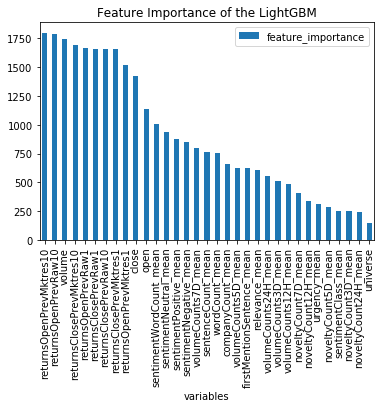

In [27]:
lgb_feature_importance.plot.bar(x='variables')
plt.title("Feature Importance of the LightGBM")

In [28]:
lgb_feature_importance

,variables,feature_importance
10,returnsOpenPrevMktres10,1800
8,returnsOpenPrevRaw10,1785
0,volume,1742
9,returnsClosePrevMktres10,1690
4,returnsOpenPrevRaw1,1666
3,returnsClosePrevRaw1,1662
7,returnsClosePrevRaw10,1659
5,returnsClosePrevMktres1,1657
6,returnsOpenPrevMktres1,1520
1,close,1425


In [38]:
lgb_auc = lgb_model.best_score['valid_1']['auc']

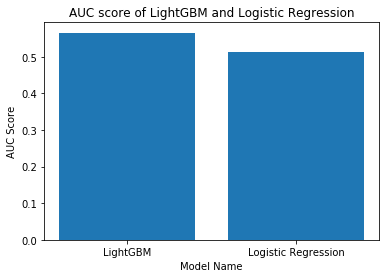

In [39]:
y_bar = [lgb_auc, clf_auc]
x_bar = ['LightGBM', 'Logistic Regression']

plt.bar(x_bar, y_bar)
plt.title('AUC score of LightGBM and Logistic Regression')
plt.xlabel('Model Name')
plt.ylabel('AUC Score')
plt.show()

In comparison between the two models, it shoes that the LightGBM is a better model which give s a better auc score. It would be ideal if we can further tune this model to find a better AUC score before making any prediction. 

## LIGHTGBM TUNING 

To further optimize the accuracy of the LightGBM model, we can vary the following features:
+ use large max_bin
+ use small learning_rate in addition to increasing the num_iterations or the num_boost_rounds (these two parameters are the same)
+ use large num_leaves
+ use bigger training dataset (not applicable in our case)
+ try using 'dart' method 
+ or try using categorical features directly

In this case, using large max_bin can signifcantly slow down our working process due to the amount of data points that were given in this project while using a large num_leaves may cause over-fitting. The last option, which is to use categorical features directly are not really appropriate in this scenario since the data-preprocessing already eliminated the categories due to its irrelevance to the ability to predict the market returns. Thus, we can either combine using small learning_rate with increasing the num_boost_round or use 'dart' method to see if one of those methods would help us improve the accuracy of the LightGBM model. 

In [40]:
#Try smaller learning_rate and increasing the num_boost_round
params_trial1 = {'learning_rate': 0.01, 
                 'max_depth': 10, 
                 'objective': 'binary', 
                 'metric': 'auc', 
                 'seed': 123}

start_time = time.time()
lgb_model_trial1 = lgb.train(params_trial1, train_set=lgb.Dataset(X_train, label=y_train), 
                             num_boost_round=2000, valid_sets=[lgb.Dataset(X_train, label=y_train),
                                                               lgb.Dataset(X_test, label=y_test)], 
                             early_stopping_rounds=100)
print ('The training time using LightGBM with smaller learning_rate and higher number of boosting rounds is: {}'.format(time.time()-start_time))

[1]	valid_0's auc: 0.555536	valid_1's auc: 0.554539
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.555678	valid_1's auc: 0.554659
[3]	valid_0's auc: 0.555683	valid_1's auc: 0.554653
[4]	valid_0's auc: 0.55568	valid_1's auc: 0.554659
[5]	valid_0's auc: 0.556053	valid_1's auc: 0.555014
[6]	valid_0's auc: 0.556055	valid_1's auc: 0.554995
[7]	valid_0's auc: 0.556273	valid_1's auc: 0.555248
[8]	valid_0's auc: 0.55634	valid_1's auc: 0.555329
[9]	valid_0's auc: 0.556464	valid_1's auc: 0.555493
[10]	valid_0's auc: 0.556666	valid_1's auc: 0.55577
[11]	valid_0's auc: 0.556703	valid_1's auc: 0.555831
[12]	valid_0's auc: 0.556866	valid_1's auc: 0.55603
[13]	valid_0's auc: 0.556927	valid_1's auc: 0.556042
[14]	valid_0's auc: 0.557219	valid_1's auc: 0.556355
[15]	valid_0's auc: 0.557265	valid_1's auc: 0.556382
[16]	valid_0's auc: 0.557285	valid_1's auc: 0.556422
[17]	valid_0's auc: 0.557447	valid_1's auc: 0.556626
[18]	valid_0's auc: 0.5575	valid_1's auc: 0.55667

[155]	valid_0's auc: 0.560901	valid_1's auc: 0.560059
[156]	valid_0's auc: 0.560913	valid_1's auc: 0.560066
[157]	valid_0's auc: 0.560929	valid_1's auc: 0.560075
[158]	valid_0's auc: 0.560941	valid_1's auc: 0.560088
[159]	valid_0's auc: 0.560954	valid_1's auc: 0.560095
[160]	valid_0's auc: 0.560969	valid_1's auc: 0.56011
[161]	valid_0's auc: 0.560987	valid_1's auc: 0.560122
[162]	valid_0's auc: 0.561004	valid_1's auc: 0.560135
[163]	valid_0's auc: 0.561016	valid_1's auc: 0.560146
[164]	valid_0's auc: 0.561028	valid_1's auc: 0.560153
[165]	valid_0's auc: 0.56104	valid_1's auc: 0.560165
[166]	valid_0's auc: 0.561055	valid_1's auc: 0.560172
[167]	valid_0's auc: 0.561069	valid_1's auc: 0.560179
[168]	valid_0's auc: 0.561083	valid_1's auc: 0.560192
[169]	valid_0's auc: 0.561097	valid_1's auc: 0.560206
[170]	valid_0's auc: 0.561111	valid_1's auc: 0.560214
[171]	valid_0's auc: 0.561127	valid_1's auc: 0.560229
[172]	valid_0's auc: 0.561136	valid_1's auc: 0.560237
[173]	valid_0's auc: 0.561153	

[308]	valid_0's auc: 0.562761	valid_1's auc: 0.561538
[309]	valid_0's auc: 0.56277	valid_1's auc: 0.561544
[310]	valid_0's auc: 0.562779	valid_1's auc: 0.56155
[311]	valid_0's auc: 0.562792	valid_1's auc: 0.561561
[312]	valid_0's auc: 0.562802	valid_1's auc: 0.561567
[313]	valid_0's auc: 0.562811	valid_1's auc: 0.561572
[314]	valid_0's auc: 0.562825	valid_1's auc: 0.561583
[315]	valid_0's auc: 0.562832	valid_1's auc: 0.561588
[316]	valid_0's auc: 0.562841	valid_1's auc: 0.561593
[317]	valid_0's auc: 0.562852	valid_1's auc: 0.561601
[318]	valid_0's auc: 0.562861	valid_1's auc: 0.561608
[319]	valid_0's auc: 0.562867	valid_1's auc: 0.561612
[320]	valid_0's auc: 0.56288	valid_1's auc: 0.561623
[321]	valid_0's auc: 0.562893	valid_1's auc: 0.561635
[322]	valid_0's auc: 0.562902	valid_1's auc: 0.56164
[323]	valid_0's auc: 0.562915	valid_1's auc: 0.561651
[324]	valid_0's auc: 0.562923	valid_1's auc: 0.561657
[325]	valid_0's auc: 0.562935	valid_1's auc: 0.561668
[326]	valid_0's auc: 0.562945	va

[461]	valid_0's auc: 0.564269	valid_1's auc: 0.56263
[462]	valid_0's auc: 0.564278	valid_1's auc: 0.562635
[463]	valid_0's auc: 0.564286	valid_1's auc: 0.56264
[464]	valid_0's auc: 0.564293	valid_1's auc: 0.562645
[465]	valid_0's auc: 0.564302	valid_1's auc: 0.562651
[466]	valid_0's auc: 0.56431	valid_1's auc: 0.562655
[467]	valid_0's auc: 0.564318	valid_1's auc: 0.56266
[468]	valid_0's auc: 0.564324	valid_1's auc: 0.562663
[469]	valid_0's auc: 0.564333	valid_1's auc: 0.562668
[470]	valid_0's auc: 0.564341	valid_1's auc: 0.562672
[471]	valid_0's auc: 0.564349	valid_1's auc: 0.562677
[472]	valid_0's auc: 0.564355	valid_1's auc: 0.562679
[473]	valid_0's auc: 0.564365	valid_1's auc: 0.562687
[474]	valid_0's auc: 0.564373	valid_1's auc: 0.562692
[475]	valid_0's auc: 0.564381	valid_1's auc: 0.562696
[476]	valid_0's auc: 0.564388	valid_1's auc: 0.562701
[477]	valid_0's auc: 0.564397	valid_1's auc: 0.562706
[478]	valid_0's auc: 0.564403	valid_1's auc: 0.562709
[479]	valid_0's auc: 0.564414	va

[614]	valid_0's auc: 0.565331	valid_1's auc: 0.563234
[615]	valid_0's auc: 0.565336	valid_1's auc: 0.563234
[616]	valid_0's auc: 0.565344	valid_1's auc: 0.563237
[617]	valid_0's auc: 0.565348	valid_1's auc: 0.563238
[618]	valid_0's auc: 0.565353	valid_1's auc: 0.563238
[619]	valid_0's auc: 0.565357	valid_1's auc: 0.563239
[620]	valid_0's auc: 0.565362	valid_1's auc: 0.563241
[621]	valid_0's auc: 0.565367	valid_1's auc: 0.563243
[622]	valid_0's auc: 0.565375	valid_1's auc: 0.563248
[623]	valid_0's auc: 0.565381	valid_1's auc: 0.563252
[624]	valid_0's auc: 0.565385	valid_1's auc: 0.563253
[625]	valid_0's auc: 0.56539	valid_1's auc: 0.563253
[626]	valid_0's auc: 0.565398	valid_1's auc: 0.563257
[627]	valid_0's auc: 0.565405	valid_1's auc: 0.563262
[628]	valid_0's auc: 0.565413	valid_1's auc: 0.563265
[629]	valid_0's auc: 0.56542	valid_1's auc: 0.563268
[630]	valid_0's auc: 0.565424	valid_1's auc: 0.56327
[631]	valid_0's auc: 0.565428	valid_1's auc: 0.563272
[632]	valid_0's auc: 0.565434	v

[767]	valid_0's auc: 0.566151	valid_1's auc: 0.563545
[768]	valid_0's auc: 0.566156	valid_1's auc: 0.563547
[769]	valid_0's auc: 0.566166	valid_1's auc: 0.563553
[770]	valid_0's auc: 0.566169	valid_1's auc: 0.563554
[771]	valid_0's auc: 0.566175	valid_1's auc: 0.563558
[772]	valid_0's auc: 0.56618	valid_1's auc: 0.563557
[773]	valid_0's auc: 0.566183	valid_1's auc: 0.563558
[774]	valid_0's auc: 0.566189	valid_1's auc: 0.563561
[775]	valid_0's auc: 0.566193	valid_1's auc: 0.563561
[776]	valid_0's auc: 0.566203	valid_1's auc: 0.563568
[777]	valid_0's auc: 0.566212	valid_1's auc: 0.563575
[778]	valid_0's auc: 0.566216	valid_1's auc: 0.563575
[779]	valid_0's auc: 0.566222	valid_1's auc: 0.563576
[780]	valid_0's auc: 0.566229	valid_1's auc: 0.56358
[781]	valid_0's auc: 0.566232	valid_1's auc: 0.563581
[782]	valid_0's auc: 0.566239	valid_1's auc: 0.563585
[783]	valid_0's auc: 0.566245	valid_1's auc: 0.563589
[784]	valid_0's auc: 0.566248	valid_1's auc: 0.563589
[785]	valid_0's auc: 0.566252	

[920]	valid_0's auc: 0.566933	valid_1's auc: 0.563824
[921]	valid_0's auc: 0.566938	valid_1's auc: 0.563824
[922]	valid_0's auc: 0.566944	valid_1's auc: 0.563826
[923]	valid_0's auc: 0.56695	valid_1's auc: 0.56383
[924]	valid_0's auc: 0.566955	valid_1's auc: 0.56383
[925]	valid_0's auc: 0.566958	valid_1's auc: 0.563831
[926]	valid_0's auc: 0.566966	valid_1's auc: 0.563834
[927]	valid_0's auc: 0.566971	valid_1's auc: 0.563835
[928]	valid_0's auc: 0.566977	valid_1's auc: 0.563838
[929]	valid_0's auc: 0.566983	valid_1's auc: 0.563841
[930]	valid_0's auc: 0.566986	valid_1's auc: 0.563842
[931]	valid_0's auc: 0.566989	valid_1's auc: 0.563843
[932]	valid_0's auc: 0.566993	valid_1's auc: 0.563843
[933]	valid_0's auc: 0.566997	valid_1's auc: 0.563844
[934]	valid_0's auc: 0.567001	valid_1's auc: 0.563845
[935]	valid_0's auc: 0.567008	valid_1's auc: 0.563846
[936]	valid_0's auc: 0.567013	valid_1's auc: 0.563846
[937]	valid_0's auc: 0.567021	valid_1's auc: 0.563853
[938]	valid_0's auc: 0.567027	v

[1071]	valid_0's auc: 0.567744	valid_1's auc: 0.564091
[1072]	valid_0's auc: 0.567751	valid_1's auc: 0.564093
[1073]	valid_0's auc: 0.567755	valid_1's auc: 0.564095
[1074]	valid_0's auc: 0.567759	valid_1's auc: 0.564094
[1075]	valid_0's auc: 0.567764	valid_1's auc: 0.564095
[1076]	valid_0's auc: 0.567768	valid_1's auc: 0.564096
[1077]	valid_0's auc: 0.567777	valid_1's auc: 0.564099
[1078]	valid_0's auc: 0.567782	valid_1's auc: 0.564101
[1079]	valid_0's auc: 0.567791	valid_1's auc: 0.564107
[1080]	valid_0's auc: 0.567797	valid_1's auc: 0.564109
[1081]	valid_0's auc: 0.567802	valid_1's auc: 0.564112
[1082]	valid_0's auc: 0.567807	valid_1's auc: 0.564113
[1083]	valid_0's auc: 0.56781	valid_1's auc: 0.564113
[1084]	valid_0's auc: 0.567813	valid_1's auc: 0.564113
[1085]	valid_0's auc: 0.567818	valid_1's auc: 0.564114
[1086]	valid_0's auc: 0.567822	valid_1's auc: 0.564115
[1087]	valid_0's auc: 0.567828	valid_1's auc: 0.564116
[1088]	valid_0's auc: 0.567832	valid_1's auc: 0.564115
[1089]	vali

[1221]	valid_0's auc: 0.568498	valid_1's auc: 0.564311
[1222]	valid_0's auc: 0.568503	valid_1's auc: 0.564311
[1223]	valid_0's auc: 0.568507	valid_1's auc: 0.564312
[1224]	valid_0's auc: 0.568512	valid_1's auc: 0.564313
[1225]	valid_0's auc: 0.568517	valid_1's auc: 0.564314
[1226]	valid_0's auc: 0.568521	valid_1's auc: 0.564314
[1227]	valid_0's auc: 0.568523	valid_1's auc: 0.564314
[1228]	valid_0's auc: 0.568527	valid_1's auc: 0.564314
[1229]	valid_0's auc: 0.568533	valid_1's auc: 0.564318
[1230]	valid_0's auc: 0.56854	valid_1's auc: 0.564319
[1231]	valid_0's auc: 0.568542	valid_1's auc: 0.564319
[1232]	valid_0's auc: 0.568548	valid_1's auc: 0.564321
[1233]	valid_0's auc: 0.568552	valid_1's auc: 0.564322
[1234]	valid_0's auc: 0.568559	valid_1's auc: 0.564326
[1235]	valid_0's auc: 0.568563	valid_1's auc: 0.564327
[1236]	valid_0's auc: 0.568568	valid_1's auc: 0.564328
[1237]	valid_0's auc: 0.568572	valid_1's auc: 0.564329
[1238]	valid_0's auc: 0.568576	valid_1's auc: 0.56433
[1239]	valid

[1371]	valid_0's auc: 0.569181	valid_1's auc: 0.564474
[1372]	valid_0's auc: 0.569185	valid_1's auc: 0.564474
[1373]	valid_0's auc: 0.56919	valid_1's auc: 0.564476
[1374]	valid_0's auc: 0.569194	valid_1's auc: 0.564475
[1375]	valid_0's auc: 0.5692	valid_1's auc: 0.564477
[1376]	valid_0's auc: 0.569204	valid_1's auc: 0.564477
[1377]	valid_0's auc: 0.569208	valid_1's auc: 0.564479
[1378]	valid_0's auc: 0.56921	valid_1's auc: 0.564478
[1379]	valid_0's auc: 0.569213	valid_1's auc: 0.564478
[1380]	valid_0's auc: 0.569219	valid_1's auc: 0.564481
[1381]	valid_0's auc: 0.569224	valid_1's auc: 0.564485
[1382]	valid_0's auc: 0.569228	valid_1's auc: 0.564485
[1383]	valid_0's auc: 0.569233	valid_1's auc: 0.564486
[1384]	valid_0's auc: 0.569239	valid_1's auc: 0.56449
[1385]	valid_0's auc: 0.569242	valid_1's auc: 0.56449
[1386]	valid_0's auc: 0.569246	valid_1's auc: 0.56449
[1387]	valid_0's auc: 0.569249	valid_1's auc: 0.56449
[1388]	valid_0's auc: 0.569254	valid_1's auc: 0.56449
[1389]	valid_0's au

[1521]	valid_0's auc: 0.569811	valid_1's auc: 0.564606
[1522]	valid_0's auc: 0.569817	valid_1's auc: 0.564607
[1523]	valid_0's auc: 0.569821	valid_1's auc: 0.56461
[1524]	valid_0's auc: 0.569825	valid_1's auc: 0.564611
[1525]	valid_0's auc: 0.569831	valid_1's auc: 0.564614
[1526]	valid_0's auc: 0.569834	valid_1's auc: 0.564615
[1527]	valid_0's auc: 0.569838	valid_1's auc: 0.564614
[1528]	valid_0's auc: 0.569843	valid_1's auc: 0.564616
[1529]	valid_0's auc: 0.569847	valid_1's auc: 0.564617
[1530]	valid_0's auc: 0.56985	valid_1's auc: 0.564617
[1531]	valid_0's auc: 0.569856	valid_1's auc: 0.564619
[1532]	valid_0's auc: 0.569862	valid_1's auc: 0.564622
[1533]	valid_0's auc: 0.569867	valid_1's auc: 0.564624
[1534]	valid_0's auc: 0.569872	valid_1's auc: 0.564623
[1535]	valid_0's auc: 0.569876	valid_1's auc: 0.564625
[1536]	valid_0's auc: 0.569884	valid_1's auc: 0.564629
[1537]	valid_0's auc: 0.569886	valid_1's auc: 0.564629
[1538]	valid_0's auc: 0.569889	valid_1's auc: 0.564629
[1539]	valid

[1671]	valid_0's auc: 0.570445	valid_1's auc: 0.56475
[1672]	valid_0's auc: 0.570452	valid_1's auc: 0.564755
[1673]	valid_0's auc: 0.570459	valid_1's auc: 0.564757
[1674]	valid_0's auc: 0.570463	valid_1's auc: 0.564757
[1675]	valid_0's auc: 0.570467	valid_1's auc: 0.564758
[1676]	valid_0's auc: 0.570471	valid_1's auc: 0.56476
[1677]	valid_0's auc: 0.570476	valid_1's auc: 0.564761
[1678]	valid_0's auc: 0.570483	valid_1's auc: 0.564766
[1679]	valid_0's auc: 0.570488	valid_1's auc: 0.564767
[1680]	valid_0's auc: 0.570493	valid_1's auc: 0.564768
[1681]	valid_0's auc: 0.570495	valid_1's auc: 0.564768
[1682]	valid_0's auc: 0.570501	valid_1's auc: 0.564771
[1683]	valid_0's auc: 0.570506	valid_1's auc: 0.564771
[1684]	valid_0's auc: 0.570509	valid_1's auc: 0.564771
[1685]	valid_0's auc: 0.570513	valid_1's auc: 0.564772
[1686]	valid_0's auc: 0.570515	valid_1's auc: 0.564771
[1687]	valid_0's auc: 0.570518	valid_1's auc: 0.564771
[1688]	valid_0's auc: 0.570521	valid_1's auc: 0.564771
[1689]	valid

[1821]	valid_0's auc: 0.571035	valid_1's auc: 0.564866
[1822]	valid_0's auc: 0.571037	valid_1's auc: 0.564866
[1823]	valid_0's auc: 0.571042	valid_1's auc: 0.564866
[1824]	valid_0's auc: 0.571045	valid_1's auc: 0.564866
[1825]	valid_0's auc: 0.571047	valid_1's auc: 0.564866
[1826]	valid_0's auc: 0.57105	valid_1's auc: 0.564867
[1827]	valid_0's auc: 0.571052	valid_1's auc: 0.564868
[1828]	valid_0's auc: 0.571056	valid_1's auc: 0.564868
[1829]	valid_0's auc: 0.571061	valid_1's auc: 0.56487
[1830]	valid_0's auc: 0.571066	valid_1's auc: 0.564871
[1831]	valid_0's auc: 0.57107	valid_1's auc: 0.56487
[1832]	valid_0's auc: 0.571072	valid_1's auc: 0.56487
[1833]	valid_0's auc: 0.571075	valid_1's auc: 0.564871
[1834]	valid_0's auc: 0.571079	valid_1's auc: 0.564871
[1835]	valid_0's auc: 0.571083	valid_1's auc: 0.564872
[1836]	valid_0's auc: 0.571087	valid_1's auc: 0.564873
[1837]	valid_0's auc: 0.571091	valid_1's auc: 0.564873
[1838]	valid_0's auc: 0.571095	valid_1's auc: 0.564873
[1839]	valid_0'

[1971]	valid_0's auc: 0.571618	valid_1's auc: 0.564959
[1972]	valid_0's auc: 0.57162	valid_1's auc: 0.56496
[1973]	valid_0's auc: 0.571627	valid_1's auc: 0.564963
[1974]	valid_0's auc: 0.57163	valid_1's auc: 0.564963
[1975]	valid_0's auc: 0.571635	valid_1's auc: 0.564963
[1976]	valid_0's auc: 0.571637	valid_1's auc: 0.564962
[1977]	valid_0's auc: 0.57164	valid_1's auc: 0.564962
[1978]	valid_0's auc: 0.571643	valid_1's auc: 0.564962
[1979]	valid_0's auc: 0.571645	valid_1's auc: 0.564961
[1980]	valid_0's auc: 0.571648	valid_1's auc: 0.564961
[1981]	valid_0's auc: 0.571651	valid_1's auc: 0.564961
[1982]	valid_0's auc: 0.571657	valid_1's auc: 0.564963
[1983]	valid_0's auc: 0.57166	valid_1's auc: 0.564963
[1984]	valid_0's auc: 0.571665	valid_1's auc: 0.564964
[1985]	valid_0's auc: 0.571668	valid_1's auc: 0.564966
[1986]	valid_0's auc: 0.571673	valid_1's auc: 0.564965
[1987]	valid_0's auc: 0.571676	valid_1's auc: 0.564965
[1988]	valid_0's auc: 0.57168	valid_1's auc: 0.564965
[1989]	valid_0's

In [41]:
lgb_model.params

{'learning_rate': 0.1,
 'max_depth': 10,
 'objective': 'binary',
 'metric': ['accuracy', 'auc', 'log_loss'],
 'seed': 123}

In [42]:
#Try using 'dart' method
params_trial2 = {'learning_rate': 0.1, 
                 'max_depth': 10, 
                 'objective': 'binary', 
                 'metric': 'auc', 
                 'seed': 123, 
                 'boosting_type': 'dart'}

start_time = time.time()
lgb_model_trial2 = lgb.train(params_trial2, train_set=lgb.Dataset(X_train, label=y_train), 
                             num_boost_round=1000, valid_sets=[lgb.Dataset(X_train, label=y_train),
                                                               lgb.Dataset(X_test, label=y_test)], 
                             early_stopping_rounds=100)
print ('The training time using LightGBM with dart as a boosting type is: {}'.format(time.time()-start_time))

[1]	valid_0's auc: 0.555536	valid_1's auc: 0.554539
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.556702	valid_1's auc: 0.55589
[3]	valid_0's auc: 0.55784	valid_1's auc: 0.557126
[4]	valid_0's auc: 0.558378	valid_1's auc: 0.557678
[5]	valid_0's auc: 0.558461	valid_1's auc: 0.557746
[6]	valid_0's auc: 0.558525	valid_1's auc: 0.557832
[7]	valid_0's auc: 0.55872	valid_1's auc: 0.557995
[8]	valid_0's auc: 0.55872	valid_1's auc: 0.557995
[9]	valid_0's auc: 0.559065	valid_1's auc: 0.558369
[10]	valid_0's auc: 0.559327	valid_1's auc: 0.558728
[11]	valid_0's auc: 0.559552	valid_1's auc: 0.558902
[12]	valid_0's auc: 0.559569	valid_1's auc: 0.558913
[13]	valid_0's auc: 0.559711	valid_1's auc: 0.559044
[14]	valid_0's auc: 0.559852	valid_1's auc: 0.559143
[15]	valid_0's auc: 0.55982	valid_1's auc: 0.559098
[16]	valid_0's auc: 0.560005	valid_1's auc: 0.559252
[17]	valid_0's auc: 0.559993	valid_1's auc: 0.559253
[18]	valid_0's auc: 0.560119	valid_1's auc: 0.5594

[155]	valid_0's auc: 0.564573	valid_1's auc: 0.562857
[156]	valid_0's auc: 0.564603	valid_1's auc: 0.562877
[157]	valid_0's auc: 0.56459	valid_1's auc: 0.562871
[158]	valid_0's auc: 0.564596	valid_1's auc: 0.562874
[159]	valid_0's auc: 0.564625	valid_1's auc: 0.562882
[160]	valid_0's auc: 0.564649	valid_1's auc: 0.562908
[161]	valid_0's auc: 0.564695	valid_1's auc: 0.562903
[162]	valid_0's auc: 0.56475	valid_1's auc: 0.562946
[163]	valid_0's auc: 0.564798	valid_1's auc: 0.562991
[164]	valid_0's auc: 0.564788	valid_1's auc: 0.562984
[165]	valid_0's auc: 0.564829	valid_1's auc: 0.562987
[166]	valid_0's auc: 0.564893	valid_1's auc: 0.563031
[167]	valid_0's auc: 0.564877	valid_1's auc: 0.563021
[168]	valid_0's auc: 0.564941	valid_1's auc: 0.563082
[169]	valid_0's auc: 0.564922	valid_1's auc: 0.56307
[170]	valid_0's auc: 0.564974	valid_1's auc: 0.563099
[171]	valid_0's auc: 0.56503	valid_1's auc: 0.563142
[172]	valid_0's auc: 0.565083	valid_1's auc: 0.563176
[173]	valid_0's auc: 0.565149	va

[308]	valid_0's auc: 0.567076	valid_1's auc: 0.564273
[309]	valid_0's auc: 0.567064	valid_1's auc: 0.564267
[310]	valid_0's auc: 0.567092	valid_1's auc: 0.564272
[311]	valid_0's auc: 0.567137	valid_1's auc: 0.564277
[312]	valid_0's auc: 0.56718	valid_1's auc: 0.56429
[313]	valid_0's auc: 0.567226	valid_1's auc: 0.564315
[314]	valid_0's auc: 0.567274	valid_1's auc: 0.564338
[315]	valid_0's auc: 0.567315	valid_1's auc: 0.564354
[316]	valid_0's auc: 0.567364	valid_1's auc: 0.56438
[317]	valid_0's auc: 0.567413	valid_1's auc: 0.564406
[318]	valid_0's auc: 0.567458	valid_1's auc: 0.564414
[319]	valid_0's auc: 0.567449	valid_1's auc: 0.56441
[320]	valid_0's auc: 0.567442	valid_1's auc: 0.564407
[321]	valid_0's auc: 0.567482	valid_1's auc: 0.564425
[322]	valid_0's auc: 0.567531	valid_1's auc: 0.564456
[323]	valid_0's auc: 0.56759	valid_1's auc: 0.564491
[324]	valid_0's auc: 0.567654	valid_1's auc: 0.564518
[325]	valid_0's auc: 0.567638	valid_1's auc: 0.564512
[326]	valid_0's auc: 0.567678	val

[461]	valid_0's auc: 0.568867	valid_1's auc: 0.564886
[462]	valid_0's auc: 0.568902	valid_1's auc: 0.564916
[463]	valid_0's auc: 0.568891	valid_1's auc: 0.564911
[464]	valid_0's auc: 0.568939	valid_1's auc: 0.56493
[465]	valid_0's auc: 0.568974	valid_1's auc: 0.564948
[466]	valid_0's auc: 0.568966	valid_1's auc: 0.564946
[467]	valid_0's auc: 0.568952	valid_1's auc: 0.56494
[468]	valid_0's auc: 0.568986	valid_1's auc: 0.56496
[469]	valid_0's auc: 0.568975	valid_1's auc: 0.564955
[470]	valid_0's auc: 0.56896	valid_1's auc: 0.56495
[471]	valid_0's auc: 0.568993	valid_1's auc: 0.564963
[472]	valid_0's auc: 0.568979	valid_1's auc: 0.564958
[473]	valid_0's auc: 0.56897	valid_1's auc: 0.564954
[474]	valid_0's auc: 0.568961	valid_1's auc: 0.56495
[475]	valid_0's auc: 0.568996	valid_1's auc: 0.564954
[476]	valid_0's auc: 0.568985	valid_1's auc: 0.56495
[477]	valid_0's auc: 0.569016	valid_1's auc: 0.564963
[478]	valid_0's auc: 0.569063	valid_1's auc: 0.564983
[479]	valid_0's auc: 0.56905	valid_1

[614]	valid_0's auc: 0.570231	valid_1's auc: 0.565274
[615]	valid_0's auc: 0.570225	valid_1's auc: 0.565272
[616]	valid_0's auc: 0.570217	valid_1's auc: 0.565269
[617]	valid_0's auc: 0.570213	valid_1's auc: 0.565267
[618]	valid_0's auc: 0.570206	valid_1's auc: 0.565264
[619]	valid_0's auc: 0.570221	valid_1's auc: 0.565261
[620]	valid_0's auc: 0.570213	valid_1's auc: 0.565259
[621]	valid_0's auc: 0.570199	valid_1's auc: 0.565254
[622]	valid_0's auc: 0.57019	valid_1's auc: 0.565251
[623]	valid_0's auc: 0.570182	valid_1's auc: 0.565249
[624]	valid_0's auc: 0.57017	valid_1's auc: 0.565244
[625]	valid_0's auc: 0.570184	valid_1's auc: 0.565259
[626]	valid_0's auc: 0.570198	valid_1's auc: 0.565265
[627]	valid_0's auc: 0.570193	valid_1's auc: 0.565261
[628]	valid_0's auc: 0.570188	valid_1's auc: 0.565261
[629]	valid_0's auc: 0.570215	valid_1's auc: 0.565247
[630]	valid_0's auc: 0.570233	valid_1's auc: 0.56524
[631]	valid_0's auc: 0.570222	valid_1's auc: 0.565235
[632]	valid_0's auc: 0.570217	v

[767]	valid_0's auc: 0.572058	valid_1's auc: 0.565606
[768]	valid_0's auc: 0.572053	valid_1's auc: 0.565605
[769]	valid_0's auc: 0.572044	valid_1's auc: 0.565603
[770]	valid_0's auc: 0.572041	valid_1's auc: 0.565601
[771]	valid_0's auc: 0.572038	valid_1's auc: 0.565599
[772]	valid_0's auc: 0.572059	valid_1's auc: 0.565604
[773]	valid_0's auc: 0.572088	valid_1's auc: 0.565615
[774]	valid_0's auc: 0.57212	valid_1's auc: 0.565626
[775]	valid_0's auc: 0.572157	valid_1's auc: 0.565639
[776]	valid_0's auc: 0.572199	valid_1's auc: 0.565646
[777]	valid_0's auc: 0.57223	valid_1's auc: 0.565663
[778]	valid_0's auc: 0.572275	valid_1's auc: 0.565666
[779]	valid_0's auc: 0.572266	valid_1's auc: 0.565665
[780]	valid_0's auc: 0.572262	valid_1's auc: 0.565663
[781]	valid_0's auc: 0.57229	valid_1's auc: 0.565666
[782]	valid_0's auc: 0.572286	valid_1's auc: 0.565665
[783]	valid_0's auc: 0.572325	valid_1's auc: 0.565667
[784]	valid_0's auc: 0.572374	valid_1's auc: 0.565704
[785]	valid_0's auc: 0.572364	v

[920]	valid_0's auc: 0.574162	valid_1's auc: 0.565967
[921]	valid_0's auc: 0.574202	valid_1's auc: 0.565989
[922]	valid_0's auc: 0.574223	valid_1's auc: 0.566
[923]	valid_0's auc: 0.574212	valid_1's auc: 0.565997
[924]	valid_0's auc: 0.574203	valid_1's auc: 0.565996
[925]	valid_0's auc: 0.574201	valid_1's auc: 0.565995
[926]	valid_0's auc: 0.574194	valid_1's auc: 0.565993
[927]	valid_0's auc: 0.574189	valid_1's auc: 0.565991
[928]	valid_0's auc: 0.57421	valid_1's auc: 0.566
[929]	valid_0's auc: 0.574231	valid_1's auc: 0.565995
[930]	valid_0's auc: 0.574268	valid_1's auc: 0.566
[931]	valid_0's auc: 0.574265	valid_1's auc: 0.565998
[932]	valid_0's auc: 0.574296	valid_1's auc: 0.566001
[933]	valid_0's auc: 0.574323	valid_1's auc: 0.566007
[934]	valid_0's auc: 0.574369	valid_1's auc: 0.566039
[935]	valid_0's auc: 0.574365	valid_1's auc: 0.566037
[936]	valid_0's auc: 0.574361	valid_1's auc: 0.566036
[937]	valid_0's auc: 0.57438	valid_1's auc: 0.566038
[938]	valid_0's auc: 0.574415	valid_1's

In [43]:
#see what attributes available in the lgb model booster object
lgb_model.__dict__.keys()

dict_keys(['handle', 'network', '_Booster__need_reload_eval_info', '_Booster__train_data_name', '_Booster__attr', '_Booster__set_objective_to_none', 'best_iteration', 'best_score', 'name_valid_sets', '_Booster__num_dataset', '_Booster__init_predictor', '_Booster__num_class', '_Booster__inner_predict_buffer', '_Booster__is_predicted_cur_iter', '_Booster__num_inner_eval', '_Booster__name_inner_eval', '_Booster__higher_better_inner_eval', 'pandas_categorical', 'params'])

In [44]:
lgb_model_list = [lgb_model, lgb_model_trial1, lgb_model_trial2]
auc_training_list = []
auc_testing_list = []

for model in lgb_model_list:
    auc_training = model.best_score['valid_0']['auc']
    auc_testing = model.best_score['valid_1']['auc']
    auc_training_list.append(auc_training)
    auc_testing_list.append(auc_testing)
    
lgb_auc_df = pd.DataFrame({'model': ['lgb_model', 'lgb_model_trial1', 'lgb_model_trial2'], 
                           'auc_training': auc_training_list, 
                           'auc_testing': auc_testing_list})

lgb_auc_df = lgb_auc_df.sort_values(['auc_training', 'auc_testing'], ascending=[False, False])

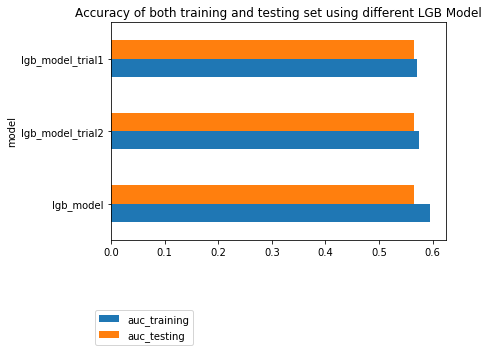

In [46]:
lgb_auc_df.plot.barh(x='model')
plt.title ('Accuracy of both training and testing set using different LGB Model')
plt.legend(loc='upper center',bbox_to_anchor=(0.1, -0.3))

Based on the generated plot above, the two different approaches that we did for tuning the LightGBM model did not give us much of an improvement. Therefore, we can just use the original model (lgb_model) to make predictions for this study. 